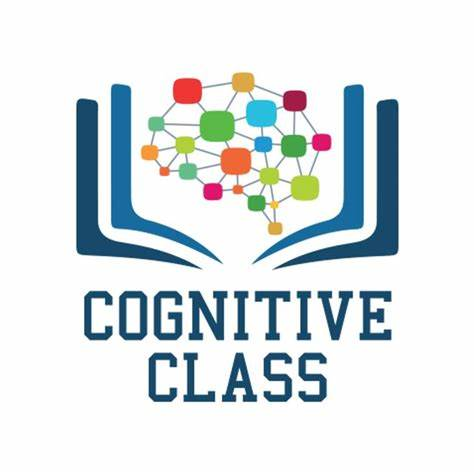

#Space X Falcon 9 First Stage Landing Prediction


**Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia**

Estimated time needed: 40 minutes

In this lab, you will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled List of Falcon 9 and Falcon Heavy launches

https://en.wikipedia.org/wiki/List_of_Falcon\_9\_and_Falcon_Heavy_launches

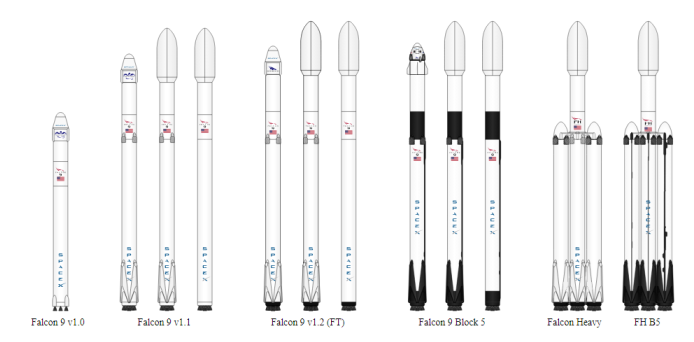


Falcon 9 first stage will land successfully

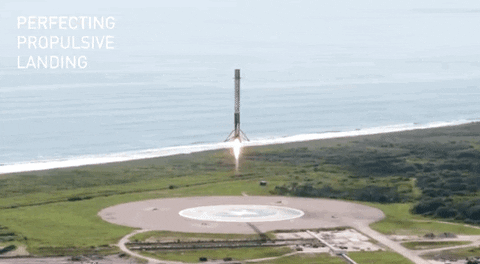

Several examples of an unsuccessful landing are shown here:


More specifically, the launch records are stored in a HTML table shown below:



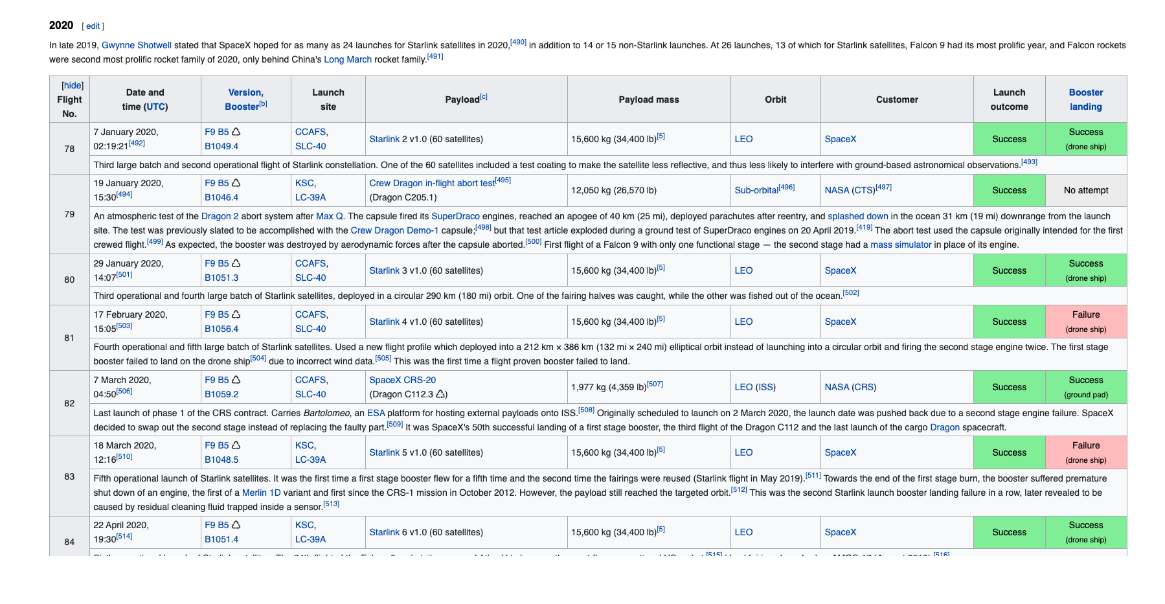


#Objectives

Web scrap Falcon 9 launch records with BeautifulSoup:

* Extract a Falcon 9 launch records HTML table from Wikipedia
* Parse the table and convert it into a Pandas data frame

First let's import required packages for this lab



In [1]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

and we will provide some helper functions for you to process web scraped HTML table



In [3]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the List of Falcon 9 and Falcon Heavy launches Wikipage updated on 9th June 2021

In [4]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"


Next, request the HTML page from the above URL and get a response object



#TASK 1: Request the Falcon9 Launch Wiki page from its URL


First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.



In [6]:
# use requests.get() method with the provided static_url
# assign the response to a object
response = requests.get(static_url)

Create a BeautifulSoup object from the HTML response



In [7]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(response.text, 'html')

Print the page title to verify if the BeautifulSoup object was created properly

In [8]:
# Use soup.title attribute
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

#TASK 2: Extract all column/variable names from the HTML table header


Next, we want to collect all relevant column names from the HTML table header

Let's try to find all tables on the wiki page first. If you need to refresh your memory about BeautifulSoup, please check the external reference link towards the end of this lab

In [9]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')

Starting from the third table is our target table contains the actual launch records.



In [10]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
<tr>
<th rowspan="2" scope="row" style="text-align:center;">1
</th>
<td>

You should able to see the columns names embedded in the table header elements <th> as follows:




<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>


Next, we just need to iterate through the <th> elements and apply the provided extract_column_from_header() to extract column name one by one

In [11]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
tc = first_launch_table.find_all('th')
for th in tc:
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
            column_names.append(name)

Check the extracted column names



In [12]:
print(column_names)


['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


#TASK 3: Create a data frame by parsing the launch HTML tables


We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe

In [13]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the launch_dict with launch records extracted from table rows.

Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links B0004.1[8], missing values N/A [e], inconsistent formatting, etc.

To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the launch_dict. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:

In [14]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element
        row=rows.find_all('td')
        #if it is number save cells in a dictonary
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            #print(flight_number)
            launch_dict['Flight No.'].append(flight_number)

            datatimelist=date_time(row[0])

            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            #print(date)
            launch_dict['Date'].append(date)

            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            #print(time)
            launch_dict['Time'].append(time)

            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            print(bv)
            launch_dict['Version Booster'].append(bv)

            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            #print(launch_site)
            launch_dict['Launch site'].append(launch_site)

            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            #print(payload)
            launch_dict['Payload'].append(payload)

            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            #print(payload)
            launch_dict['Payload mass'].append(payload_mass)

            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            #print(orbit)
            launch_dict['Orbit'].append(orbit)

            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a != None:
                customer = row[6].a.string
            else:
                customer = ''
            #print(customer)
            launch_dict['Customer'].append(customer)

            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            #print(launch_outcome)
            launch_dict['Launch outcome'].append(launch_outcome)


            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            #print(booster_landing)
            launch_dict['Booster landing'].append(booster_landing)


F9 v1.0B0003.1
F9 v1.0B0004.1
F9 v1.0B0005.1
F9 v1.0B0006.1
F9 v1.0B0007.1
F9 v1.1B1003
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 v1.1
F9 FT
F9 v1.1
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT
F9 FT♺
F9 FT
F9 FT
F9 FT
F9 FTB1029.2
F9 FT
F9 FT
F9 B4
F9 FT
F9 B4
F9 B4
F9 FTB1031.2
F9 B4
F9 FTB1035.2
F9 FTB1036.2
F9 B4
F9 FTB1032.2
F9 FTB1038.2
F9 B4
F9 B4B1041.2
F9 B4B1039.2
F9 B4
F9 B5B1046.1
F9 B4B1043.2
F9 B4B1040.2
F9 B4B1045.2
F9 B5
F9 B5B1048
F9 B5B1046.2
F9 B5
F9 B5B1048.2
F9 B5B1047.2
F9 B5B1046.3
F9 B5
F9 B5
F9 B5B1049.2
F9 B5B1048.3
F9 B5[268]
F9 B5
F9 B5B1049.3
F9 B5B1051.2
F9 B5B1056.2
F9 B5B1047.3
F9 B5
F9 B5
F9 B5B1056.3
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5B1058.2
F9 B5
F9 B5B1049.6
F9 B5
F9 B5B1060.2
F9 B5B1058.3
F9 B5B1051.6
F9 B5
F9 B5
F9 B5
F9 B5
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5
F9 B5B1051.8
F9 B5B1058.5
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5 ♺
F9 B5B1060.6
F9

In [15]:
for k in launch_dict.keys():
    print("Key {} => Len {}".format(k, len(k)))

Key Flight No. => Len 10
Key Launch site => Len 11
Key Payload => Len 7
Key Payload mass => Len 12
Key Orbit => Len 5
Key Customer => Len 8
Key Launch outcome => Len 14
Key Version Booster => Len 15
Key Booster landing => Len 15
Key Date => Len 4
Key Time => Len 4


After you have fill in the parsed launch record values into launch_dict, you can create a dataframe from it.



In [16]:
launch_dict
df=pd.DataFrame(launch_dict)
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,F9 B5B1067.1,Success,3 June 2021,17:29



We can now export it to a CSV for the next section, but to make the answers consistent and in case you have difficulties finishing this lab.

Following labs will be using a provided dataset to make each lab independent

In [17]:
df.to_csv('spacex_web_scraped_tpf.csv', index=False)


# Authors

Yan Luo

Nayef Abou Tayoun

#Change Log


Date (YYYY-MM-DD)	Version	Changed By	Change Description
2021-06-09	1.0	Yan Luo	Tasks updates
2020-11-10	1.0	Nayef	Created the initial version

Copyright © 2021 IBM Corporation. All rights reserved.
